# Попытка сделать двухэтапную модель

## Импорт библиотек и константы

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import shap
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import xgboost as xgb
from lightgbm import LGBMRanker, LGBMClassifier
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, NDCG, Recall, Serendipity, calc_metrics
from rectools.model_selection import TimeRangeSplitter

In [3]:
RANDOM_STATE = 0

## Загрузка данных

Оптимизируем память для хранения датафремов через приведение типов

In [4]:
lightfm_recommendations_df = pd.read_csv("new_data/lightfm_recommendations.csv")
lightfm_recommendations_df = lightfm_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
lightfm_recommendations_df = lightfm_recommendations_df.rename({"score": "lightfm_score", "rank": "lightfm_rank"}, axis=1)

In [5]:
userknn_recommendations_df = pd.read_csv("new_data/userknn_recommendations.csv")
userknn_recommendations_df = userknn_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
userknn_recommendations_df = userknn_recommendations_df.rename({"score": "userknn_score", "rank": "userknn_rank"}, axis=1)

In [6]:
popular_recommendations_df = pd.read_csv("new_data/popular_recommendations.csv")
popular_recommendations_df = popular_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
popular_recommendations_df = popular_recommendations_df.rename({"score": "popular_score", "rank": "popular_rank"}, axis=1)

In [7]:
test_df = pd.read_csv("new_data/ranker_test_data.csv")
test_df = test_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'weight': 'float32', 'total_dur': 'int32'}
)

In [8]:
train_df = pd.read_csv("new_data/ranker_train_data.csv")
train_df = train_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'weight': 'float32', 'total_dur': 'int32'}
)

valid_df = pd.read_csv("new_data/ranker_valid_data.csv")
valid_df = valid_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'weight': 'float32', 'total_dur': 'int32'}
)

In [9]:
users_df = pd.read_csv("new_data/user_new_features_data.csv")
users_df = users_df.astype(
    {
        'user_id': 'int32', 'age': 'int8', 'income': 'int8', 'sex': 'int8', 'kids_flg': 'int8',
        'user_history': 'int32', 'user_avg_popularity': 'float32', 'user_last_popularity': 'float32',
        'serials_count': 'int16', 'films_count': 'int16', 'serials_part': 'float16',
    }
)

items_df = pd.read_csv("new_data/item_new_features_data.csv")
items_df = items_df.astype(
    {
        'item_id': 'int32', 'content_type': 'int8', 'release_year_cat': 'int8', 'for_kids': 'int8', 'age_rating': 'int8',
        'actors_count': 'int32', 'description_len': 'int32', 'american': 'int8', 'russian': 'int8', 'soviet': 'int8',
        'item_popularity': 'float32', 'item_avg_history': 'float32'
    }
)

In [10]:
models_results = pd.read_csv("new_data/first_stage_models.csv", index_col=0)

In [11]:
with open("new_data/users_default_values.json", "r") as f:
    users_default_features = json.load(f)

In [12]:
with open("new_data/user_features_mapping.json", "r") as f:
    users_features_mapping = json.load(f)

In [13]:
users_features_inv_mapping = dict()
for key in users_features_mapping:
    users_features_inv_mapping[key] = dict()
    for (k, v) in users_features_mapping[key].items():
        users_features_inv_mapping[key][v] = k

In [14]:
users_default_features = {
    **users_default_features,
    "age": int(users_features_inv_mapping["age"]["age_unknown"]),
    "income": int(users_features_inv_mapping["income"]["income_unknown"]),
    "sex": int(users_features_inv_mapping["sex"]["sex_unknown"]),
    "kids_flg": int(users_features_inv_mapping["kids_flg"]["kids_flg_0"]),
}

## Подготовка данных для обучения

In [15]:
def get_users(users, n=100):
    for user_id in users:
        for _ in range(n):
            yield user_id

In [16]:
train_users = train_df["user_id"].unique()
# получаем рекомендации популярного для всех юзеров из тренировочного датасета
# просто копируем датафрейм с популярными по количеству юзеров и правильно расставляем user_id
train_popular_reco_df = pd.concat([popular_recommendations_df] * len(train_users))
train_popular_reco_df["user_id"] = list(get_users(train_users))

In [17]:
# соединяем популярные рекомендации и LIGHTFM так чтобы попали все рекомендации
recommendations_df = (
    pd.merge(
        train_popular_reco_df, 
        lightfm_recommendations_df[lightfm_recommendations_df["user_id"].isin(train_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# продолжаем соединять, но уже UserKNN
recommendations_df = (
    pd.merge(
        recommendations_df, 
        userknn_recommendations_df[userknn_recommendations_df["user_id"].isin(train_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# соединяем с данными для обучения так, чтобы сохранить примеры для обучения (так как нам интересны и холодные юзеры тоже)
recommendations_df = (
    pd.merge(
        recommendations_df, 
        train_df, 
        how='right',
        on=['user_id', 'item_id']
    )
)

# заполняем пропуски и оптимизируемся по памяти
recommendations_df = (
    recommendations_df[["user_id", "item_id", "weight", "lightfm_score", "lightfm_rank", "userknn_score", "userknn_rank", "popular_score", "popular_rank"]]
    .fillna(
        {
            'lightfm_score': 0, 'lightfm_rank': 101,
            'userknn_score': 0, 'userknn_rank': 101,
            'popular_score': 0, 'popular_rank': 101,
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'lightfm_score': 'float16', 'lightfm_rank': 'int16',
            'userknn_score': 'float16', 'userknn_rank': 'int16',
            'popular_score': 'float16', 'popular_rank': 'int16'
        }
    )
    
)

# добавляем юзеров и айтемы
recommendations_df = pd.merge(
    recommendations_df,
    users_df,
    how='left', 
    on=['user_id']
)

recommendations_df = pd.merge(
    recommendations_df,
    items_df,
    how='left', 
    on=['item_id']
)

recommendations_df = recommendations_df.fillna(users_default_features)

In [18]:
is_genre_match = []
for i in tqdm(range(len(recommendations_df))):
    favorite_genre = recommendations_df.iloc[i]["favorite_genre"]
    genres = recommendations_df.iloc[i]["genres"]
    is_genre_match.append(favorite_genre in genres)
recommendations_df["is_genre_match"] = is_genre_match

  0%|          | 0/1245527 [00:00<?, ?it/s]

In [19]:
train_df = recommendations_df

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245527 entries, 0 to 1245526
Data columns (total 33 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   user_id               1245527 non-null  int32  
 1   item_id               1245527 non-null  int32  
 2   weight                1245527 non-null  float16
 3   lightfm_score         1245527 non-null  float16
 4   lightfm_rank          1245527 non-null  int16  
 5   userknn_score         1245527 non-null  float16
 6   userknn_rank          1245527 non-null  int16  
 7   popular_score         1245527 non-null  float16
 8   popular_rank          1245527 non-null  int16  
 9   age                   1245527 non-null  float64
 10  income                1245527 non-null  float64
 11  sex                   1245527 non-null  float64
 12  kids_flg              1245527 non-null  float64
 13  user_history          1245527 non-null  float64
 14  user_avg_popularity   1245527 non-

## Подготовка данных для валидации

In [21]:
valid_users = valid_df["user_id"].unique()
# получаем рекомендации популярного для всех юзеров из тренировочного датасета
# просто копируем датафрейм с популярными по количеству юзеров и правильно расставляем user_id
valid_popular_reco_df = pd.concat([popular_recommendations_df] * len(valid_users))
valid_popular_reco_df["user_id"] = list(get_users(valid_users))

In [22]:
# соединяем популярные рекомендации и LIGHTFM так чтобы попали все рекомендации
recommendations_df = (
    pd.merge(
        valid_popular_reco_df, 
        lightfm_recommendations_df[lightfm_recommendations_df["user_id"].isin(valid_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# продолжаем соединять, но уже UserKNN
recommendations_df = (
    pd.merge(
        recommendations_df, 
        userknn_recommendations_df[userknn_recommendations_df["user_id"].isin(valid_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# соединяем с данными для валидации так, чтобы сохранить примеры для обучения (так как нам интересны и холодные юзеры тоже)
recommendations_df = (
    pd.merge(
        recommendations_df, 
        valid_df, 
        how='right',
        on=['user_id', 'item_id']
    )
)

# заполняем пропуски и оптимизируемся по памяти
recommendations_df = (
    recommendations_df[["user_id", "item_id", "weight", "lightfm_score", "lightfm_rank", "userknn_score", "userknn_rank", "popular_score", "popular_rank"]]
    .fillna(
        {
            'lightfm_score': 0, 'lightfm_rank': 101,
            'userknn_score': 0, 'userknn_rank': 101,
            'popular_score': 0, 'popular_rank': 101,
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'lightfm_score': 'float16', 'lightfm_rank': 'int16',
            'userknn_score': 'float16', 'userknn_rank': 'int16',
            'popular_score': 'float16', 'popular_rank': 'int16'
        }
    )
    
)

# добавляем юзеров и айтемы
recommendations_df = pd.merge(
    recommendations_df,
    users_df,
    how='left', 
    on=['user_id']
)

recommendations_df = pd.merge(
    recommendations_df,
    items_df,
    how='left', 
    on=['item_id']
)

recommendations_df = recommendations_df.fillna(users_default_features)

In [23]:
is_genre_match = []
for i in tqdm(range(len(recommendations_df))):
    favorite_genre = recommendations_df.iloc[i]["favorite_genre"]
    genres = recommendations_df.iloc[i]["genres"]
    is_genre_match.append(favorite_genre in genres)
recommendations_df["is_genre_match"] = is_genre_match

  0%|          | 0/268321 [00:00<?, ?it/s]

In [24]:
valid_df = recommendations_df

## Подготовка данных для тестирования

In [25]:
test_users = test_df["user_id"].unique()
# получаем рекомендации популярного для всех юзеров из тренировочного датасета
# просто копируем датафрейм с популярными по количеству юзеров и правильно расставляем user_id
test_popular_reco_df = pd.concat([popular_recommendations_df] * len(test_users))
test_popular_reco_df["user_id"] = list(get_users(test_users))

In [26]:
# соединяем популярные рекомендации и LIGHTFM так чтобы попали все рекомендации
recommendations_df = (
    pd.merge(
        test_popular_reco_df, 
        lightfm_recommendations_df[lightfm_recommendations_df["user_id"].isin(test_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# продолжаем соединять, но уже UserKNN
recommendations_df = (
    pd.merge(
        recommendations_df, 
        userknn_recommendations_df[userknn_recommendations_df["user_id"].isin(test_users)], 
        how='outer',
        on=['user_id', 'item_id']
    )
)

# заполняем пропуски и оптимизируемся по памяти
recommendations_df = (
    recommendations_df[["user_id", "item_id", "lightfm_score", "lightfm_rank", "userknn_score", "userknn_rank", "popular_score", "popular_rank"]]
    .fillna(
        {
            'lightfm_score': 0, 'lightfm_rank': 101,
            'userknn_score': 0, 'userknn_rank': 101,
            'popular_score': 0, 'popular_rank': 101,
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32',
            'lightfm_score': 'float16', 'lightfm_rank': 'int16',
            'userknn_score': 'float16', 'userknn_rank': 'int16',
            'popular_score': 'float16', 'popular_rank': 'int16'
        }
    )
    
)

# добавляем юзеров и айтемы
recommendations_df = pd.merge(
    recommendations_df,
    users_df,
    how='left', 
    on=['user_id']
)

recommendations_df = pd.merge(
    recommendations_df,
    items_df,
    how='left', 
    on=['item_id']
)

recommendations_df = recommendations_df.fillna(users_default_features)

In [27]:
is_genre_match = []
for i in tqdm(range(len(recommendations_df))):
    favorite_genre = recommendations_df.iloc[i]["favorite_genre"]
    genres = recommendations_df.iloc[i]["genres"]
    is_genre_match.append(favorite_genre in genres)
recommendations_df["is_genre_match"] = is_genre_match

  0%|          | 0/9135136 [00:00<?, ?it/s]

In [28]:
test_extra_df = recommendations_df

## Создание таргета

Создадим таргет на основе процента просмотра фильма:
- 0: доля досмотра < 10%
- 1: 10% <=  доля досмотра < 70%
- 2: 70% <= доля досмотра

In [29]:
def to_target(x):
    if x < 10:
        return 0
    elif x < 70:
        return 1
    else:
        return 2

In [30]:
train_df['target_ranker'] = train_df[Columns.Weight].apply(to_target).astype(int)
valid_df['target_ranker'] = valid_df[Columns.Weight].apply(to_target).astype(int)
test_df['target_ranker'] = test_df[Columns.Weight].apply(to_target).astype(int)

In [31]:
train_df = train_df.sort_values(by=['user_id', 'item_id'])
valid_df = valid_df.sort_values(by=['user_id', 'item_id'])
test_df = test_df.sort_values(by=['user_id', 'item_id'])

In [32]:
metrics = {
    'ndcg@10': NDCG(k = 10),
    'map@10': MAP(k = 10),
    'recall@10': Recall(k = 10),
    'serendipity@10': Serendipity(k=10)
}

## Обучение ранкера от LightGBM

In [33]:
def get_group(df):
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [34]:
# Колонки, которые будут участвовать в обучении (с учетом моделей первого уровня)
cols = [
    'lightfm_score', 'lightfm_rank', 'userknn_rank', 'popular_score', 'popular_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_history', 'user_avg_popularity', 'user_last_popularity',
    'serials_count', 'films_count', 'serials_part',
    'content_type', 'release_year_cat', 'for_kids', 'age_rating', 'item_popularity', 'item_avg_history',
    'actors_count', 'description_len', 'american', 'russian', 'soviet'
]

# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg', 'american', 'russian', 'soviet',
    'content_type', 'release_year_cat', 'age_rating', 'for_kids',
]

In [35]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 2000,  # максимальное число деревьев
    'max_depth': 5,  # максимальная глубина дерева
    'num_leaves': 16,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.05,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': -1,  # период вывода метрик
    'random_state': RANDOM_STATE,
}
fit_params = {
    'X': train_df[cols],
    'y': train_df['target_ranker'],
    'group': get_group(train_df),
    'eval_set': [(valid_df[cols], valid_df['target_ranker'])],
    'eval_group': [get_group(valid_df)],
    'eval_metric': 'ndcg',
    'eval_at': (1, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

listwise_df = test_extra_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_extra_df[cols])
listwise_df.sort_values(["user_id", "listwise_score"], ascending=False)
listwise_df["listwise_rank"] = listwise_df.groupby("user_id").cumcount() + 1

In [36]:
%%timeit
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

17 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        test_df
        [[Columns.User, Columns.Item, Columns.Weight]]
    ), 
    prev_interactions=(
        train_df
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=test_df['item_id'].unique()
)

In [57]:
models_results["LightGBMRanker"] = [listwise_metrics[metric] for metric in models_results.index]

In [58]:
models_results

,LightFM,UserKNN_BM25,Popular,LightGBMRanker,XGBoostRanker
ndcg@10,0.032116,0.032472,0.035194,0.076413,0.076413
map@10,0.042491,0.042748,0.047337,0.127436,0.127436
recall@10,0.083713,0.081155,0.096176,0.246643,0.246643
serendipity@10,0.000253,0.000150,0.000075,0.000013,0.000013


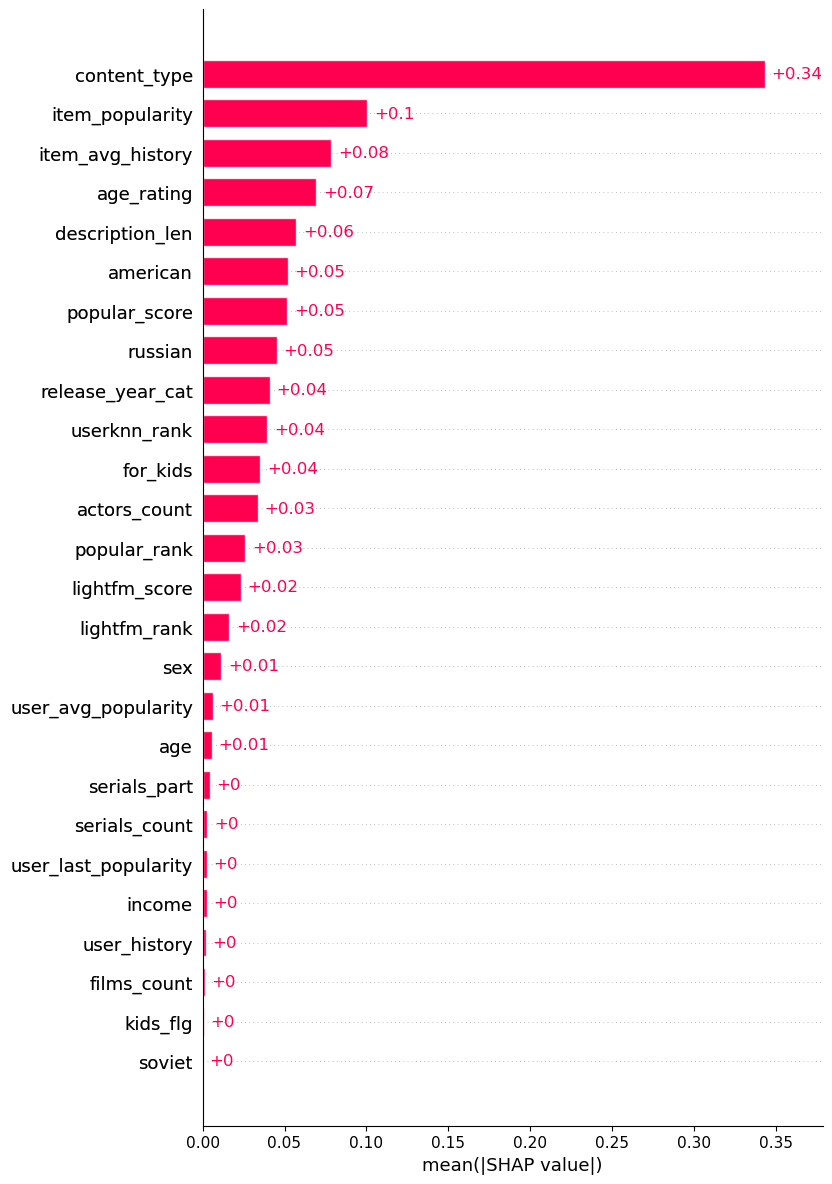

In [40]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_extra_df[cols].iloc[:20_000])
shap.plots.bar(shap_values, max_display=len(cols))

## Обучение ранкера от XGBoost

У библиотеки XGBoost немного отличается по формату группы для обучения

In [41]:
def get_xgboost_group(df):
    counts = train_df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id'].values
    group_id = 1
    for count in counts:
        for i in range(count):
            yield group_id
        group_id += 1

In [42]:
quids = list(get_xgboost_group(train_df))

In [43]:
xgb_cols = [
    'lightfm_score', 'lightfm_rank', 'userknn_rank', 'popular_score', 'popular_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_history', 'user_avg_popularity', 'user_last_popularity',
    'serials_count', 'films_count', 'serials_part',
    'content_type', 'release_year_cat', 'for_kids', 'age_rating', 'item_popularity', 'item_avg_history',
    'actors_count', 'description_len', 'american', 'russian', 'soviet'
]

In [44]:
xgb_model = xgb.XGBRanker(
    n_estimators=1000,
    max_depth=7,
    max_leaves=16,
    learning_rate=0.1,
    tree_method="hist", 
    lambdarank_num_pair_per_sample=8, 
    objective="rank:ndcg", 
    lambdarank_pair_method="topk"
)
xgb_model.fit(train_df[xgb_cols], train_df['target_ranker'], qid=quids)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=8, lambdarank_pair_method='topk',
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
          max_leaves=16, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=1000,
          n_jobs=None, ...)

In [45]:
%%timeit
xgb_model = xgb.XGBRanker(
    n_estimators=1000,
    max_depth=7,
    max_leaves=16,
    learning_rate=0.1,
    tree_method="hist", 
    lambdarank_num_pair_per_sample=8, 
    objective="rank:ndcg", 
    lambdarank_pair_method="topk"
)
xgb_model.fit(train_df[xgb_cols], train_df['target_ranker'], qid=quids)

1min 8s ± 4.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
xgb_df = test_extra_df[["user_id", "item_id"]].copy()
xgb_df["xgb_score"] = xgb_model.predict(test_extra_df[xgb_cols])
xgb_df.sort_values(["user_id", "xgb_score"], ascending=False)
xgb_df["xgb_rank"] = xgb_df.groupby("user_id").cumcount() + 1

In [53]:
xgb_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        xgb_df
        .rename(columns={'xgb_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        test_df
        [[Columns.User, Columns.Item, Columns.Weight]]
    ), 
    prev_interactions=(
        train_df
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=test_df['item_id'].unique()
)

In [54]:
models_results["XGBoostRanker"] = [xgb_metrics[metric] for metric in models_results.index]

In [55]:
models_results

,LightFM,UserKNN_BM25,Popular,LightGBMRanker,XGBoostRanker
ndcg@10,0.032116,0.032472,0.035194,0.076413,0.076413
map@10,0.042491,0.042748,0.047337,0.127436,0.127436
recall@10,0.083713,0.081155,0.096176,0.246643,0.246643
serendipity@10,0.000253,0.000150,0.000075,0.000005,0.000013


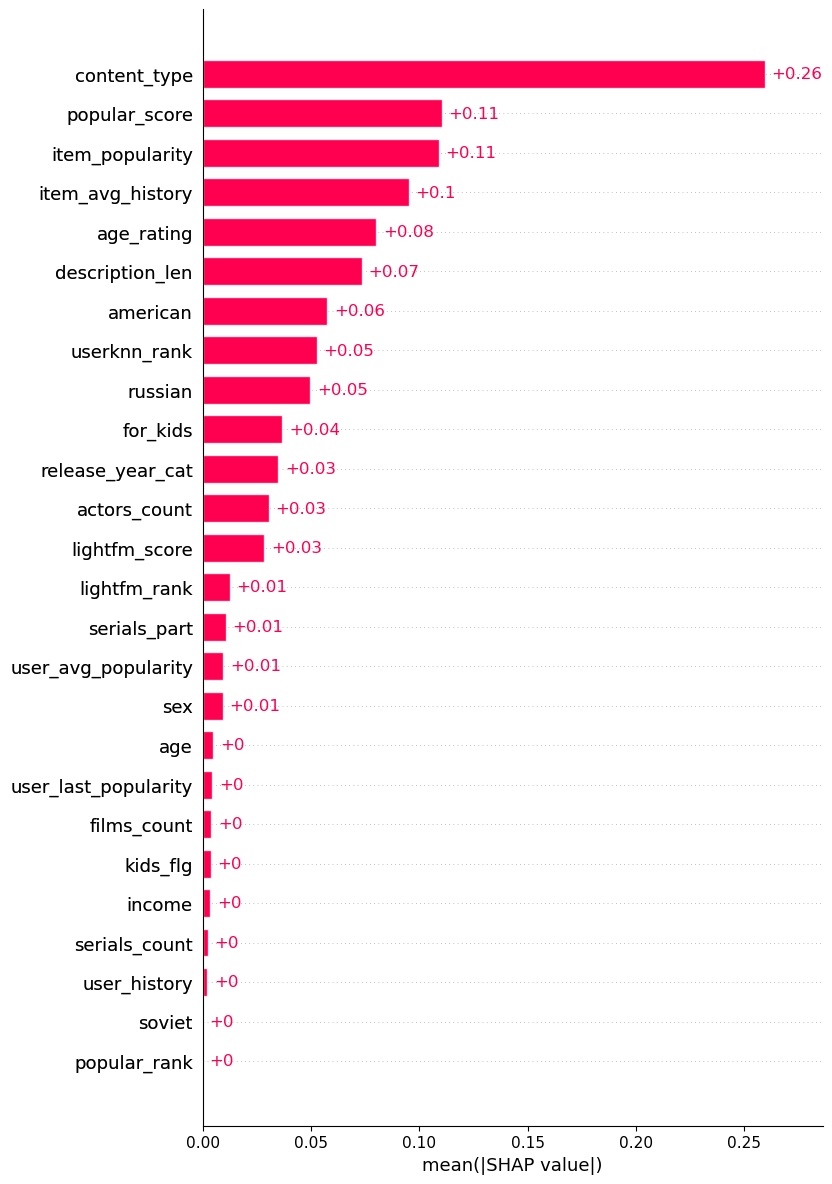

In [50]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(test_extra_df[xgb_cols].iloc[:20_000])
shap.plots.bar(shap_values, max_display=len(cols))

## Сравнение

Так как модели обучались на тех же данных и на похожих значениях параметров, то и обучились они до примерно одинакового результата (есть подозрения что они рекомендуют популярное)

По времени обучения LightGBM (17 s) справляется быстрее XGBoost (88 s)

## Подготовка оффлайн рекомендаций

In [51]:
mkdir offline_recommendations

mkdir: cannot create directory ‘offline_recommendations’: File exists


In [ ]:
batch_size = 50_000
popular_reco_df = pd.concat([popular_recommendations_df] * batch_size)

for user_border in tqdm(range(0, 1_100_000, batch_size)):
    down_border = user_border
    up_border = user_border + batch_size
    user_id_list = np.arange(down_border, up_border)
    popular_reco_df["user_id"] = list(get_users(user_id_list))

    recommendations_df = (
        pd.merge(
            popular_reco_df, 
            lightfm_recommendations_df[lightfm_recommendations_df["user_id"].isin(user_id_list)], 
            how='outer',
            on=['user_id', 'item_id']
        )
    )

    recommendations_df = (
        pd.merge(
            recommendations_df, 
            userknn_recommendations_df[userknn_recommendations_df["user_id"].isin(user_id_list)], 
            how='outer',
            on=['user_id', 'item_id']
        )
    )

    recommendations_df = (
        recommendations_df[["user_id", "item_id", "lightfm_score", "lightfm_rank", "userknn_score", "userknn_rank", "popular_score", "popular_rank"]]
        .fillna(
            {
                'lightfm_score': 0, 'lightfm_rank': 101,
                'userknn_score': 0, 'userknn_rank': 101,
                'popular_score': 0, 'popular_rank': 101,
            }
        )
        .astype(
            {
                'user_id': 'int32', 'item_id': 'int32',
                'lightfm_score': 'float16', 'lightfm_rank': 'int16',
                'userknn_score': 'float16', 'userknn_rank': 'int16',
                'popular_score': 'float16', 'popular_rank': 'int16'
            }
        )
        
    )

    recommendations_df = pd.merge(
        recommendations_df,
        users_df,
        how='left', 
        on=['user_id']
    )
    
    recommendations_df = pd.merge(
        recommendations_df,
        items_df,
        how='left', 
        on=['item_id']
    )
    
    recommendations_df = recommendations_df.fillna(users_default_features)

    predicted_df = recommendations_df[["user_id", "item_id"]].copy()
    predicted_df["score"] = listwise_model.predict(recommendations_df[cols])
    predicted_df.sort_values(["user_id", "score"], ascending=False)
    predicted_df["rank"] = predicted_df.groupby("user_id").cumcount() + 1

    predicted_df = predicted_df[predicted_df["rank"] <= 10]
    predicted_dict = predicted_df.groupby('user_id')['item_id'].apply(list).to_dict()
    with open(f"offline_recommendations/{down_border}-{up_border}.json", "w") as f:
        json.dump(predicted_dict, f)

  0%|          | 0/22 [00:00<?, ?it/s]